In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None

In [2]:
# Скачиваем датасет
load_iris = load_iris()
data  = pd.DataFrame(data = load_iris.data, columns = load_iris.feature_names)
data['target'] = load_iris.target
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Урок английского
- sepal - чашелистик
- petal - лепесток

Features
- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm

Target:

- 0 - Iris-Setosa (Ирис щетинистый)
- 1 - Iris-Versicolour (Ирис разноцветный
- 2 - Iris-Virginica (Ирис виргинский)

In [3]:
data['target_name'] = data['target'].map({0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'})
data['sepal'] = data.apply(lambda row: row['sepal length (cm)'] * row['sepal width (cm)'], axis = 1)
data['petal'] = data.apply(lambda row: row['petal length (cm)'] * row['petal length (cm)'], axis = 1)
data['target_0'] = data['target'].apply(lambda x: 1 if x == 0 else 0)
data['target_1'] = data['target'].apply(lambda x: 1 if x == 1 else 0)
data['target_2'] = data['target'].apply(lambda x: 1 if x == 2 else 0)

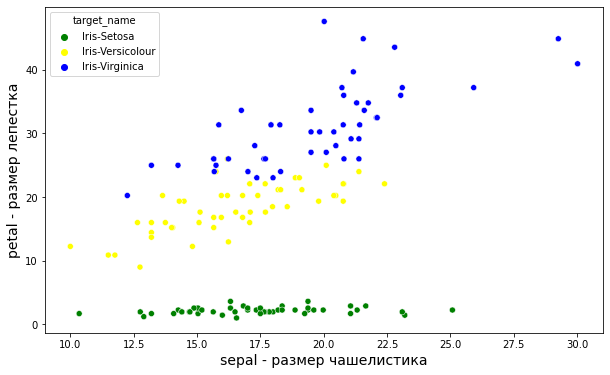

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))

p = sns.scatterplot(data = data, x = 'sepal', y='petal', hue = 'target_name', palette = ['green', 'yellow', 'blue'])

p.set_xlabel('sepal - размер чашелистика', fontsize = 14)
p.set_ylabel('petal - размер лепестка', fontsize = 14)

plt.show()

# Loss для задачи классификации

В задаче регрессии для подбора коэффициентов мы минимизировали функцию ошибки MSE на всём датасете. В задаче классификации мы будем максимизировать правдоподобие. 

**Правдоподобие** — это вероятность получить выборку наших наблюдений, то есть вероятность того, что мы имеем наш датасет с разметкой именно такой.

$$\prod_{i = 1}^{l} P(T = t_i | x_i) \rightarrow \underset{\mathbf{w}}{max}$$

где $P(T = t_i | x_i)$ — вероятность того, что таргет будет равен $t_i$, если объект обладает признаками $x_i$

С произведением работать неудобно. Поэтом возьмём логарифм. Поскольку логарифм - функция возрастающая, то желание найти максимум не поменяется на желание найти минимум.

$$ln \Big( \prod_{i = 1}^{l} P(T = t_i | x_i) \Big) \rightarrow \underset{\mathbf{w}}{max}$$

$$ \sum_{i = 1}^{l} ln \big(P(T = t_i | x_i) \big) \rightarrow \underset{\mathbf{w}}{max}$$

Домножим на минус, чтобы нам необходимо было искать минимум.

$$ L(\mathbf{w}) = -\sum_{i = 1}^{l} ln \big(P(T = t_i | x_i) \big) \rightarrow \underset{\mathbf{w}}{min}$$


**Для двух классов**
$$ \boxed{L(\mathbf{w}) = -\sum_{i = 1}^{l} \big(t_i \ln (p_i) + (1 - t_i) \ln (1 - p_i) \big) \rightarrow \underset{\mathbf{w}}{min}}$$

$t_i$ - таргет на наблюдении i<br>
$p_i$ - вероятность, которая вернула модель на наблюдении i<br>
$l$ — количество наблюдений 

**Объяснение, что при бинарной классификации получается формула из двух слагаемых.**<br>
Легко видеть, что, в завимимости от таргета каждое слагаемое суммы будет обычным логарифмом.<br><br>
$$ln \big(P(T = t_i | x_i) \big) = t_i \ln (p_i) + (1 - t_i) \ln (1 - p_i)$$

$$t_i = 1 \;\;\rightarrow\;\; ln \big(P(T = t_i | x_i) \big) = \ln (p_i)$$

$$t_i = 0 \;\;\rightarrow\;\; ln \big(P(T = t_i | x_i) \big) = \ln (1-p_i)$$ 

<br>

# Как считать вероятность?

Но как же выразить вероятность, которая присутствует в формуле для кросс-энтропии, через признаки классов?

Шансами называется отношение вероятности принадлежности к классу 1 к вероятности принадлежности к классу 2.

$$Odds = \frac{p}{1-p}$$

$$p = \frac{Odds}{Odds + 1}$$

$$p = \frac{1}{1 + 1/Odds}$$

$$p = \frac{1}{1 + e^{ln(1/Odds)}}$$

$$p = \frac{1}{1 + e^{-ln\big(Odds\big)}}$$

Стоит отметить, что: 
- Odds $\in [0, +\infty$]
- ln(Odds) $\in [-\infty, +\infty$]

Поскольку логарифм шансов может принимать любые значения от минус бесконечности до плюс бесконечности, мы можем выходы линейной модели (logits) прогонять через полученную сигмоидальную функцию. В результате обучения модели, линейные выходы будет иметь физический смысл логарифма шансов иметь целевой признак.

Обозначив линейный выход модели $log(Odds) = z$, запишем получившуюся формулу:

$$\boxed{\sigma(z) = \frac{1}{1+e^{-z}}}$$

Физический смысл коэффициентов модели 
- Intercept: Логарифм шансов иметь признак, если все категориальные и численные признаки равны нулю. 
- при числовых признаках: При единичном изменении признака, логарифм шансов изменяется на величину коэффициента.
- при категориальных признаках: При переходе к новой категории (0  $\rightarrow$ 1) логарифм шансов изменяется на величину.

# Train и Test

In [5]:
def add_folds_to_dataframe(df):
    df['Type'] = 0
    kf = KFold(shuffle=True)
    for train_index, test_index in kf.split(df.index):
        df.loc[test_index, 'Type'] = 'Test'
        df.loc[train_index, 'Type'] = 'Train'
    return df

data = add_folds_to_dataframe(data)

In [6]:
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']

# Стандартизация

In [7]:
X_train = train[['sepal', 'petal']]
X_test = test[['sepal', 'petal']]

In [8]:
# Инициализируем нормализатор.
standart_scaler_object = StandardScaler()

    # Обучаем нормализатор на численных фичах трейна.
standart_scaler_object.fit(X_train)

    # Трансформируем нормализатор на трейне и тесте.
train[['sepal_norm', 'petal_norm']] = standart_scaler_object.transform(X_train)
test[['sepal_norm', 'petal_norm']] = standart_scaler_object.transform(X_test)
data[['sepal_norm', 'petal_norm']] = standart_scaler_object.transform(data[['sepal', 'petal']])

In [9]:
X_train_norm = train[['sepal_norm', 'petal_norm']]
X_test_norm = test[['sepal_norm', 'petal_norm']]

# Функция для визуализации

https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html

https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot

https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

In [10]:
def show_devided_surface(X, y, model, target_column_name):
    """
    Функция строит тепловую карту вероятности и разделяющую поверхность
    """
    
    # 1. Ищем область, в которой будем рисовать
    X_columns = list(X.columns)
    X = X.to_numpy()
    x_min, x_max = X[:, 0].min(), X[:, 0].max() # 1st feature
    y_min, y_max = X[:, 1].min(), X[:, 1].max() # 2nd feature
    
    x_min = x_min - (x_max - x_min)/5
    x_max = x_max + (x_max - x_min)/5
    y_min = y_min - (y_max - y_min)/5
    y_max = y_max + (y_max - y_min)/5
        # создаём массив на каждую ось
    x_scale = np.linspace(x_min, x_max, 500)
    y_scale = np.linspace(y_min, y_max, 500)
        # Соединяем массивы по x и y
    x_grid, y_grid = np.meshgrid(x_scale, y_scale)

    # 2. Делаем предикт
    Z_proba = model.predict_proba(np.c_[x_grid.ravel(), y_grid.ravel()])[:, 1]
    Z_proba = Z_proba.reshape(x_grid.shape)
    Z_classes = (model.predict_proba(np.c_[x_grid.ravel(), y_grid.ravel()])[:, 1] >= 0.5).astype(int)
    Z_classes = Z_classes.reshape(x_grid.shape)

    surface = plt.contourf(x_grid, y_grid, Z_proba, 100, cmap='Oranges')
    plt.contour(x_grid, y_grid, Z_classes, colors='black')
    plt.colorbar(surface)
    sns.scatterplot(data = data, x=X_columns[0], y=X_columns[1], hue = target_column_name, style="Type")
    plt.show()

<br><br><br><br><br><br>

# Binary output

## За класс 1 принимаем (setosa)

In [11]:
y_train = train['target_0']
y_test = test['target_0']

logisticregression_object = LogisticRegression()
logisticregression_object.fit(X_train, y_train)

y_train_score = logisticregression_object.predict_proba(X_train)[:, 1]
y_test_score = logisticregression_object.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_true = y_train, y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = y_test, y_score = y_test_score), '- Test score')

1.0 - Train score
1.0 - Test score


/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


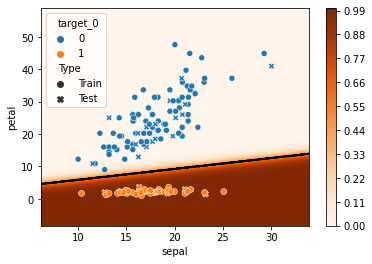

In [12]:
show_devided_surface(X_train, y_train, logisticregression_object, target_column_name = 'target_0')

In [13]:
pd.DataFrame({'features': ['intercept'] + logisticregression_object.feature_names_in_.tolist(),
              'coeffitients': [logisticregression_object.intercept_.tolist()[0]] + logisticregression_object.coef_.tolist()[0]})

,features,coeffitients
0,intercept,2.476885
1,sepal,0.330382
2,petal,-0.984184


Уравнение логистической регрессии:

$$\boxed{log(Odds_{to\;virginica}) = 2.54 + 0.33 \cdot Sepal - 1.004 \cdot Petal}$$

- Увеличение размера чашелистика (Sepal) **положительно влияет** на вероятность принадлежности цветка к классу Virginica.

- Увеличение размера лепестка (Petal) **отрицательно влияет** на вероятность принадлежности цветка к классу Virginica.

**Что можно сказать про силу влияния переменных?**<br>
Вроде как коэффициент перед sepal в 3 раза меньше, чем коэффициент перед petal, Но по сути (как мы можем наблюдать из графика), sepal ничего не значит вообще.

### Зачем нужна нормализация

In [14]:
y_train = train['target_0']
y_test = test['target_0']

logisticregression_object = LogisticRegression()
logisticregression_object.fit(X_train_norm, y_train)

y_train_score = logisticregression_object.predict_proba(X_train_norm)[:, 1]
y_test_score = logisticregression_object.predict_proba(X_test_norm)[:, 1]
print(roc_auc_score(y_true = y_train, y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = y_test, y_score = y_test_score), '- Test score')

1.0 - Train score
1.0 - Test score


/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


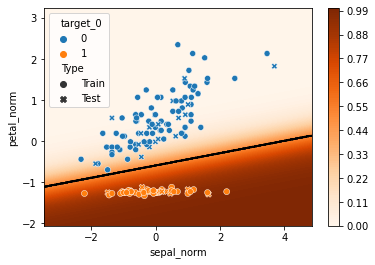

In [15]:
show_devided_surface(X_train_norm, y_train, logisticregression_object, target_column_name = 'target_0')

In [16]:
pd.DataFrame({'features': ['intercept'] + logisticregression_object.feature_names_in_.tolist(),
              'coeffitients': [logisticregression_object.intercept_.tolist()[0]] + logisticregression_object.coef_.tolist()[0]})

,features,coeffitients
0,intercept,-2.287301
1,sepal_norm,0.580827
2,petal_norm,-3.874940


In [17]:
3.891/0.5959

6.529619063601276

После стандартизации оказалось, что коэффициент перед sepal более чем в 6.5 раз меньше, чем коэффициент перед petal. <br>
**После нормализации гораздо более очевидно, что признак sepal почти не влияет на итоговую вероятность!**

<br><br><br>

## За класс 1 принимаем (versicolor)

In [18]:
y_train = train['target_1']
y_test = test['target_1']

logisticregression_object = LogisticRegression()
logisticregression_object.fit(X_train, y_train)

y_train_score = logisticregression_object.predict_proba(X_train)[:, 1]
y_test_score = logisticregression_object.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_true = y_train, y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = y_test, y_score = y_test_score), '- Test score')

0.7046875000000001 - Train score
0.745 - Test score


/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


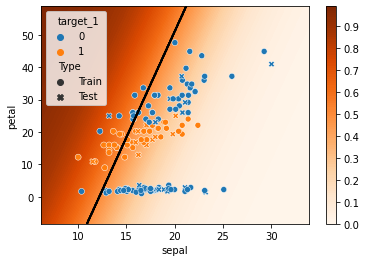

In [19]:
show_devided_surface(X_train, y_train, logisticregression_object, target_column_name = 'target_1')

In [20]:
logisticregression_object.intercept_

array([3.47971721])

In [21]:
logisticregression_object.coef_

array([[-0.28564994,  0.0437093 ]])

## За класс 1 принимаем (virginica)

In [22]:
y_train = train['target_2']
y_test = test['target_2']

logisticregression_object = LogisticRegression()
logisticregression_object.fit(X_train, y_train)

y_train_score = logisticregression_object.predict_proba(X_train)[:, 1]
y_test_score = logisticregression_object.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_true = y_train, y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = y_test, y_score = y_test_score), '- Test score')

0.9948107448107448 - Train score
0.9943181818181819 - Test score


/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


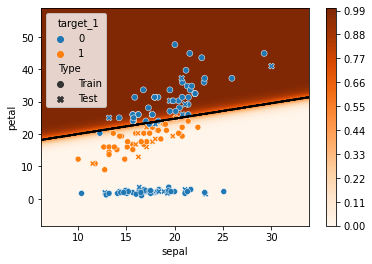

In [23]:
show_devided_surface(X_train, y_train, logisticregression_object, target_column_name = 'target_1')

In [24]:
logisticregression_object.intercept_

array([-15.04864085])

In [25]:
logisticregression_object.coef_

array([[-0.46795744,  0.98529858]])

In [26]:
import os
import sklearn
path = os.path.abspath(sklearn.__file__)
path

'/home/volodya/.local/lib/python3.10/site-packages/sklearn/__init__.py'

<br><br><br><br><br><br><br>

# Multinomial output

## OVR

Строит несколько бинарных логистических регресссий на каждый класс, как мы это делали в начале главы 4.

In [27]:
y_train = train['target']
y_test = test['target']

logisticregression_object = LogisticRegression(multi_class='ovr')
logisticregression_object.fit(X_train, y_train)

y_train_score_1 = logisticregression_object.predict_proba(X_train)[:, 1]
y_test_score_1 = logisticregression_object.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_true = train['target_1'], y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = test['target_1'], y_score = y_test_score), '- Test score')

0.4803125 - Train score
0.605 - Test score


/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


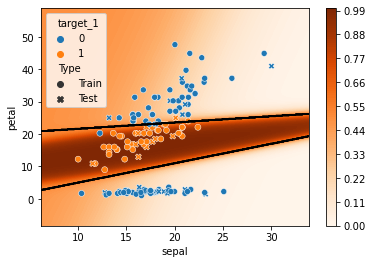

In [28]:
show_devided_surface(X_train, y_train, logisticregression_object, target_column_name = 'target_1')

In [29]:
logisticregression_object.intercept_

array([  2.47688523,   3.47971721, -15.04864085])

In [30]:
logisticregression_object.coef_

array([[ 0.33038228, -0.98418384],
       [-0.28564994,  0.0437093 ],
       [-0.46795744,  0.98529858]])

## Softmax

Строит логистическую регрессию с мультивыходом.

**Для множества классов:**

$$ \boxed{L(\mathbf{w}) = -\sum_{i = 1}^{l} \sum_{c = 0}^{N} \big[ t_c \ln (p_c) \big]_{i}\rightarrow \underset{\mathbf{w}}{min}}$$

$N$ — количество классов <br>
$l$ — количество наблюдений <br>
$[t_c]_i$ — принадлежит ли $i$ наблюдение c-му классу (1 - да, 0 - нет) <br>
$[p_c]_i$ — вероятность того, что $i$ наблюдение принадлежит c-му классу <br>

$p_c = SM_{с}\big(\vec{y}\big)$ — результат работы SoftMax (вероятность) <br>

$$p_c = SM_{c}\big(\overrightarrow{logits}\big) = \frac{e^{logits_c}}{\sum\limits_{j}^{N}e^{logits_j}}$$

$N$ — количество классов <br>
$\vec{y}$ — вектор линейных выходов на последнем слое <br>
$t_c$ — таргетное значение для класса c <br>

**Важно!**<br>
1. [Можно показать](https://stats.stackexchange.com/questions/87248/is-binary-logistic-regression-a-special-case-of-multinomial-logistic-regression), что обычная логистическая регрессия — частный случай мультикласс-логистической регрессии.

2. [Можно показать](https://chrisyeh96.github.io/2018/06/11/logistic-regression.html), что, обучив мультикласс-логистическую регрессию на бинарных данных мы можем найти, какие были бы веса при обучении обычной логистической регрессии на этих данных: 

$$W_{simple \; logistic} = W_1 - W_2$$ $$b_{simple \; logistic} = b_1 - b_2$$

где:<br>
$W_1, W_2$ — веса, идущие к 1 и 2 классам соответственно <br>
$b_1, b_2$ — смещения, идущие к 1 и 2 классам соответственно 

3. Так же, поскольку, вероятности на выходе какого-то примера в сумме должны давать 1, можно показать, что $W_1 = -W_2$, $b_1 = -b_2$

$$p_{+} = \frac{1}{1+e^{- W_1 x}}$$

$$p_{-} = \frac{1}{1+e^{- W_2 x}}$$

К сожалению, в `sklearn` нельзя запустить мультикласс-логистическую регрессию для бинарной классификации, чтобы продемонстрировать этот чудесный факт :(

In [31]:
y_train = train['target_1']
y_test = test['target_1']

logisticregression_object = LogisticRegression(multi_class='multinomial', penalty='none')
logisticregression_object.fit(X_train, y_train)

y_train_score_1 = logisticregression_object.predict_proba(X_train)[:, 1]
y_test_score_1 = logisticregression_object.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_true = train['target_1'], y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = test['target_1'], y_score = y_test_score), '- Test score')

0.4803125 - Train score
0.605 - Test score


/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/volodya/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


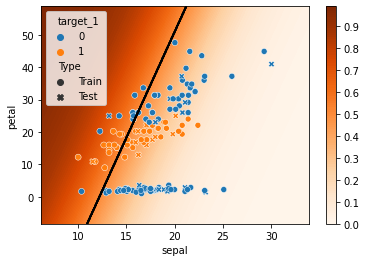

In [32]:
show_devided_surface(X_train, y_train, logisticregression_object, 'target_1')

In [33]:
logisticregression_object

LogisticRegression(multi_class='multinomial', penalty='none')

In [34]:
logisticregression_object.intercept_

array([-1.75404758,  1.75404758])

In [35]:
logisticregression_object.coef_

array([[ 0.14380798, -0.02199643],
       [-0.14380798,  0.02199643]])

# MLPClassifier

In [36]:
y_train = train['target_1']
y_test = test['target_1']
mlp = MLPClassifier(hidden_layer_sizes=(),  max_iter=2000, alpha = 0, 
                    activation='logistic', solver='lbfgs', tol=0, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=(),
              max_iter=2000, random_state=42, solver='lbfgs', tol=0)

In [37]:
mlp.coefs_

[array([[-0.28761592],
        [ 0.04399287]])]

In [38]:
mlp.intercepts_

[array([3.50809443])]

In [39]:
y_train_score_1 = mlp.predict_proba(X_train)[:, 1]
y_test_score_1 = mlp.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_true = train['target_1'], y_score = y_train_score), '- Train score')
print(roc_auc_score(y_true = test['target_1'], y_score = y_test_score), '- Test score')

0.4803125 - Train score
0.605 - Test score


https://stackoverflow.com/questions/68136462/why-dont-logisticregression-and-mlpclassifier-produce-the-same-results

## Визуализация для мульти-класс результата

In [40]:
MLPClassifier()

MLPClassifier()

In [41]:
# from sklearn.datasets import load_iris
# load_iris = load_iris()
# data  = pd.DataFrame(data = load_iris.data, columns = load_iris.feature_names)
# data['target'] = load_iris.target

# from sklearn.linear_model import LogisticRegression
# logistic_regression_objects.fit()